In [51]:
#Importing modules and libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import time


In [52]:
import torch
import torch.nn as nn
#VGG13 Architecture
class customVGG13(nn.Module):
    def __init__(self, num_classes=36):
        super(customVGG13, self).__init__()
        
        self.convblock1_1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.relublock1_1 = nn.ReLU(inplace=True)
        self.convblock1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relublock1_2 = nn.ReLU(inplace=True)
        self.poolblock1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.convblock2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relublock2_1 = nn.ReLU(inplace=True)
        self.convblock2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.relublock2_2 = nn.ReLU(inplace=True)
        self.poolblock2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.convblock3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relublock3_1 = nn.ReLU(inplace=True)
        self.convblock3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relublock3_2 = nn.ReLU(inplace=True)
        self.poolblock3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.convblock4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.relublock4_1 = nn.ReLU(inplace=True)
        self.convblock4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.relublock4_2 = nn.ReLU(inplace=True)
        self.poolblock4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fclayer1 = nn.Linear(512 * 1 * 1, 4096)
        self.relu_fclayer1 = nn.ReLU(inplace=True)
        self.dropoutlayer1 = nn.Dropout(0.5)
        
        self.fclayer2 = nn.Linear(4096, 4096)
        self.relu_fclayer2 = nn.ReLU(inplace=True)
        self.dropoutlayer2 = nn.Dropout(0.5)
        
        self.fclayer3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relublock1_1(self.convblock1_1(x))
        x = self.relublock1_2(self.convblock1_2(x))
        x = self.poolblock1(x)
        
        x = self.relublock2_1(self.convblock2_1(x))
        x = self.relublock2_2(self.convblock2_2(x))
        x = self.poolblock2(x)
        
        x = self.relublock3_1(self.convblock3_1(x))
        x = self.relublock3_2(self.convblock3_2(x))
        x = self.poolblock3(x)
    
        x = self.relublock4_1(self.convblock4_1(x))
        x = self.relublock4_2(self.convblock4_2(x))
        x = self.poolblock4(x)
        
        x = x.view(-1, 512 * 1 * 1)
        x = self.dropoutlayer1(self.relu_fclayer1(self.fclayer1(x)))
        x = self.dropoutlayer2(self.relu_fclayer2(self.fclayer2(x)))
        x = self.fclayer3(x)
        
        return x

In [53]:
import torch
print(torch.cuda.is_available()) #checking if gpu is available

True


In [54]:
#converting images to 1channel grayscale and of size 28*28
input_data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)), 
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)) 
])

#intializing batch size and epoch values
batch_size = 250
epochs = 10

#setting device to cuda if gpu is available else using cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#retrieving cnn_dataset for training
input_image_dataset = ImageFolder(root='/kaggle/input/neural-network-datatset-emnist/cnn_dataset',transform=input_data_transform)

#splitting dataset into 80% training,10% validation, and 10% testing
training_dataset_ratio = 0.8
validation_dataset_ratio = 0.1
testing_dataset_ratio = 0.1

training_dataset_size = int(len(input_image_dataset)*training_dataset_ratio)
validation_dataset_size = int(len(input_image_dataset) * validation_dataset_ratio)
testing_dataset_size = len(input_image_dataset)-training_dataset_size-validation_dataset_size 

training_dataset, validation_dataset, testing_dataset=random_split(input_image_dataset,[training_dataset_size, validation_dataset_size, testing_dataset_size],generator=torch.Generator().manual_seed(42))

#dataloader containing training, testing and validation with batch size of 250
training_dataset_loader=DataLoader(dataset=training_dataset,batch_size=batch_size,shuffle=True)
validation_dataset_loader=DataLoader(dataset=validation_dataset,batch_size=batch_size,shuffle=True)
testing_dataset_loader=DataLoader(dataset=testing_dataset,batch_size=batch_size,shuffle=True)

In [55]:
import torch
from torchinfo import summary

#initializing VGG-13 model with 36 output labels
model = customVGG13(num_classes=36)
model = model.to(device)

#model summary with 1 input channel and 28*28 image size
summary(model, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
customVGG13                              [1, 36]                   --
├─Conv2d: 1-1                            [64, 28, 28]              640
├─ReLU: 1-2                              [64, 28, 28]              --
├─Conv2d: 1-3                            [64, 28, 28]              36,928
├─ReLU: 1-4                              [64, 28, 28]              --
├─MaxPool2d: 1-5                         [64, 14, 14]              --
├─Conv2d: 1-6                            [128, 14, 14]             73,856
├─ReLU: 1-7                              [128, 14, 14]             --
├─Conv2d: 1-8                            [128, 14, 14]             147,584
├─ReLU: 1-9                              [128, 14, 14]             --
├─MaxPool2d: 1-10                        [128, 7, 7]               --
├─Conv2d: 1-11                           [256, 7, 7]               295,168
├─ReLU: 1-12                             [256, 7, 7]              

In [56]:
#check if model is utilizing GPU
print(next(model.parameters()).device)

cuda:0


In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #using Adam optimizer with learning rate of 0.001
# optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9) 
best_validation_accuracy = 0.0
# save_vgg_path = "best_weights_vgg.pth" # file to save best weights
start_training_time = time.time()
training_dataset_losses = []
validation_dataset_losses = []
training_dataset_accuracies = []
validation_dataset_accuracies = []
for epoch in range(epochs): # running model on training and validation dataset for 10 iterations(epochs)
    model.train()
    running_loss = 0.0
    correct_training_dataset = 0
    total_training_dataset = 0
    
    for training_inputs,training_labels in training_dataset_loader:
        training_inputs,training_labels=training_inputs.to(device),training_labels.to(device)
        training_outputs= model(training_inputs) 
        training_loss = criterion(training_outputs,training_labels) 
        
        optimizer.zero_grad()  
        training_loss.backward() 
        optimizer.step()
        running_loss += training_loss.item()
        
        _,predicted_training = torch.max(training_outputs, 1)
        total_training_dataset += training_labels.size(0)
        correct_training_dataset += (predicted_training == training_labels).sum().item()
    
    train_loss = running_loss/len(training_dataset_loader)
    training_dataset_losses.append(train_loss)
    training_accuracy=100*(correct_training_dataset/total_training_dataset)
    training_dataset_accuracies.append(training_accuracy)
    
    #running the model on validation dataset
    model.eval() 
    validation_loss = 0.0
    correct_validation_dataset = 0
    total_validation_dataset = 0
    
    with torch.no_grad(): 
        for validation_dataset_inputs, validation_dataset_labels in validation_dataset_loader:
            validation_dataset_inputs, validation_dataset_labels = validation_dataset_inputs.to(device), validation_dataset_labels.to(device)
            validation_dataset_outputs = model(validation_dataset_inputs)
            validation_loss += criterion(validation_dataset_outputs, validation_dataset_labels).item()
                   
            _,predicted_validation = torch.max(validation_dataset_outputs, 1)
            total_validation_dataset += validation_dataset_labels.size(0)
            correct_validation_dataset += (predicted_validation==validation_dataset_labels).sum().item()
    
    validation_loss = (validation_loss/len(validation_dataset_loader))
    validation_accuracy = 100*(correct_validation_dataset/total_validation_dataset)
    validation_dataset_losses.append(validation_loss)
    validation_dataset_accuracies.append(validation_accuracy)
    # Saving best model weights with highest validation accuracy
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        torch.save(model.state_dict(),'best_weights_vgg.pth')
        print(f"Best model weights with highest validation accuracy saved at best_weights_vgg.pth at epoch {epoch+1}")

    print(f"Epoch number [{epoch+1}/{epochs}],Training dataset Loss:{train_loss:.4f},Validation dataset Loss:{validation_loss:.4f},Training dataset Accuracy:{training_accuracy:.2f}%,Validation dataset Accuracy:{validation_accuracy:.2f}%")

end_training_time = time.time()
training_dataset_time = end_training_time-start_training_time
print(f"Total time for vgg-13 training dataset : {training_dataset_time:.2f} seconds")

Best model weights with highest validation accuracy saved at best_weights_vgg.pth at epoch 1
Epoch number [1/10],Training dataset Loss:1.4929,Validation dataset Loss:0.3341,Training dataset Accuracy:53.72%,Validation dataset Accuracy:87.70%
Best model weights with highest validation accuracy saved at best_weights_vgg.pth at epoch 2
Epoch number [2/10],Training dataset Loss:0.3225,Validation dataset Loss:0.2856,Training dataset Accuracy:88.49%,Validation dataset Accuracy:89.37%
Best model weights with highest validation accuracy saved at best_weights_vgg.pth at epoch 3
Epoch number [3/10],Training dataset Loss:0.2598,Validation dataset Loss:0.2451,Training dataset Accuracy:90.44%,Validation dataset Accuracy:90.85%
Epoch number [4/10],Training dataset Loss:0.2320,Validation dataset Loss:0.2642,Training dataset Accuracy:91.30%,Validation dataset Accuracy:90.62%
Best model weights with highest validation accuracy saved at best_weights_vgg.pth at epoch 5
Epoch number [5/10],Training dataset

In [58]:
#evaluating model on testing data
model.eval() 
testing_dataset_loss = 0.0
correct_testing_dataset = 0
total_testing_dataset = 0
testing_dataset_accuracy=0
predicted_testing_labels = []
predicted_testing_labels_output = []
actual_testing_labels = []
with torch.no_grad():
    for testing_dataset_inputs, testing_dataset_labels in testing_dataset_loader:
        testing_dataset_inputs, testing_dataset_labels = testing_dataset_inputs.to(device), testing_dataset_labels.to(device)
        testing_dataset_outputs = model(testing_dataset_inputs)
        testing_dataset_loss += criterion(testing_dataset_outputs, testing_dataset_labels).item()
            
        _, predicted_testing = torch.max(testing_dataset_outputs, 1)
        predicted_testing_probs = torch.softmax(testing_dataset_outputs, dim=1)
        total_testing_dataset += testing_dataset_labels.size(0)
        correct_testing_dataset += (predicted_testing == testing_dataset_labels).sum().item()
        predicted_testing_labels.extend(predicted_testing.cpu().numpy())
        predicted_testing_labels_output.extend(predicted_testing_probs.cpu().numpy())
        actual_testing_labels.extend(testing_dataset_labels.cpu().numpy())

predicted_testing_labels = np.array(predicted_testing_labels)
predicted_testing_labels_output = np.array(predicted_testing_labels_output)
actual_testing_labels = np.array(actual_testing_labels)
testing_dataset_loss = testing_dataset_loss/len(testing_dataset_loader)
testing_dataset_accuracy = 100 *(correct_testing_dataset/total_testing_dataset)

print(f"Testing dataset Accuracy for VGG-13:{testing_dataset_accuracy:.2f}%")
print(f"Testing dataset Loss for VGG-13:{testing_dataset_loss:.4f}")


Testing dataset Accuracy for VGG-13:91.42%
Testing dataset Loss for VGG-13:0.2687


In [59]:
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix,roc_curve
precision,recall,F1_score,_ = precision_recall_fscore_support(actual_testing_labels, predicted_testing_labels, average='weighted')
#finding Precision,Recall,F1 score
print(f"Precision for the test dataset for VGG-13:{precision:.2f}")
print(f"Recall for the test dataset for VGG-13:{recall:.2f}")
print(f"F1 Score for the test dataset for VGG-13:{F1_score:.2f}")

Precision for the test dataset for VGG-13:0.92
Recall for the test dataset for VGG-13:0.91
F1 Score for the test dataset for VGG-13:0.91


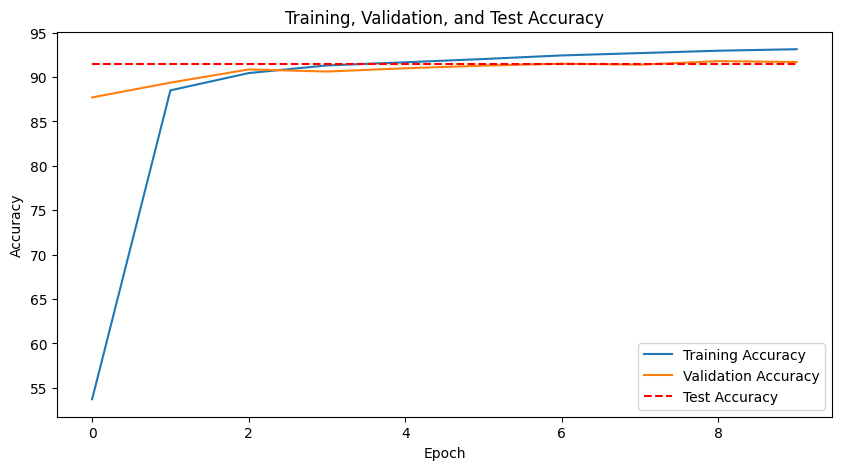

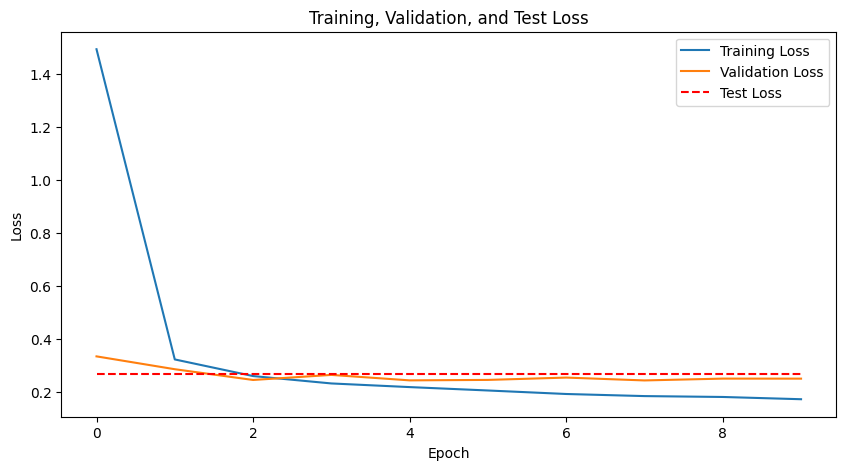

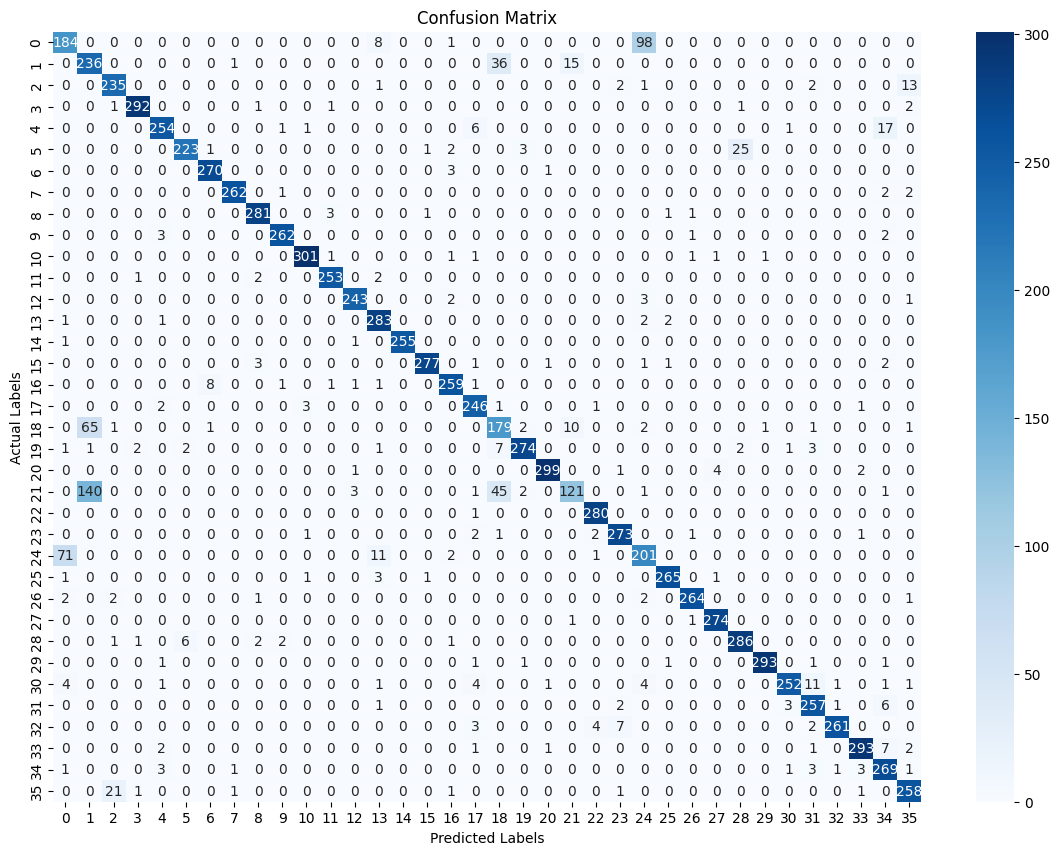

In [60]:
test_accuracies_list = [testing_dataset_accuracy] * epochs
test_losses_list = [testing_dataset_loss] * epochs

#Training,Validation and Test graph for accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_dataset_accuracies, label='Training Accuracy')
plt.plot(validation_dataset_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies_list, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test graph for losses
plt.figure(figsize=(10, 5))
plt.plot(training_dataset_losses, label='Training Loss')
plt.plot(validation_dataset_losses, label='Validation Loss')
plt.plot(test_losses_list, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Confusion Matrix
conf_matrix = confusion_matrix(actual_testing_labels, predicted_testing_labels)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

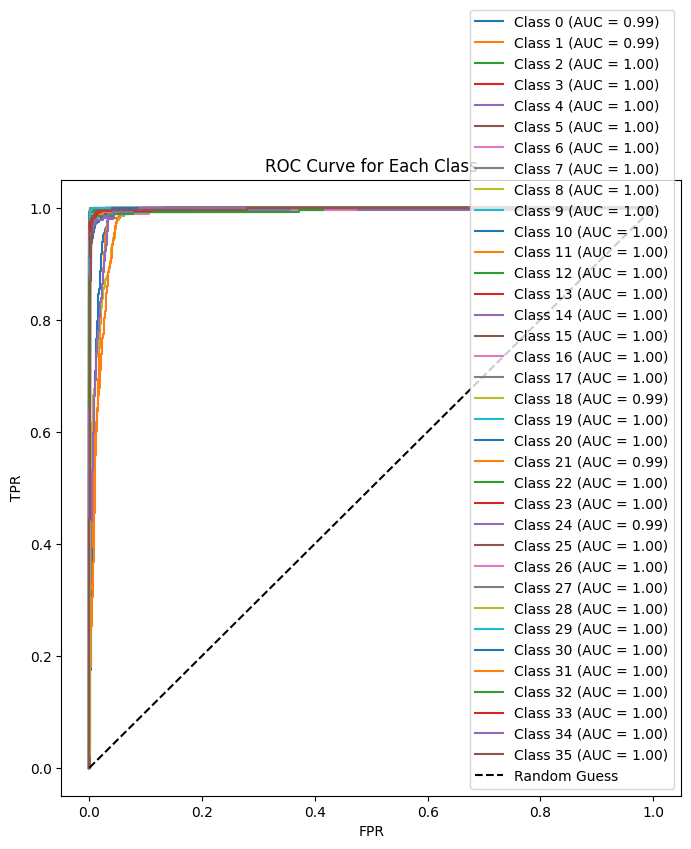

In [ ]:
 #plotting the ROC curve
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
plt.figure(figsize=(8,8))
num_classes=36
testing_dataset_labels_binarized = label_binarize(actual_testing_labels, classes=np.arange(num_classes))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(testing_dataset_labels_binarized[:, i], predicted_testing_labels_output[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], roc_auc=roc_auc[i], estimator_name=f'Class {i}').plot(ax=plt.gca())
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve for Each Class')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='lower right')
plt.show()